100 0.5000 -0.0000 2.2080 0.1555 0.6488 0.0920 4.6033 0.8406
200 1.0000 -0.0000 2.1828 0.0220 0.6425 0.0124 4.5977 0.0897
300 1.5000 0.0000 2.1793 0.0251 0.6352 0.0192 4.6146 0.1336
400 2.0000 0.0000 2.1583 0.0219 0.6410 0.0173 4.5456 0.1210
500 2.5000 0.0000 2.1602 0.0281 0.6447 0.0148 4.5389 0.1260


,timestep,timeNow,$\Sigma v$,E,$\sigma E$,Ek,$\sigma Ek$,P_1,P_2
0,100,0.5,-1.776357e-17,2.207995,0.155526,0.648773,0.092044,4.603341,0.840562
1,200,1.0,-2.942091e-17,2.182844,0.022006,0.642484,0.012409,4.597668,0.089659
2,300,1.5,1.221245e-17,2.179275,0.025134,0.635185,0.019170,4.614588,0.133551
3,400,2.0,1.706968e-17,2.158308,0.021944,0.641005,0.017318,4.545601,0.120993
4,500,2.5,1.457168e-17,2.160234,0.028112,0.644672,0.014838,4.538944,0.126002


Moviepy - Building video coo/coordinates.mp4.
Moviepy - Writing video coo/coordinates.mp4



Moviepy - Done !
Moviepy - video ready coo/coordinates.mp4


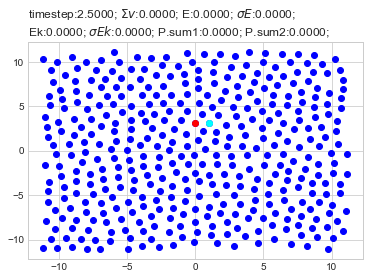

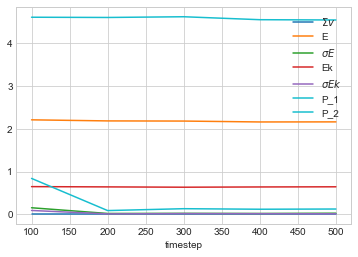

In [8]:
# 代码1：..........................................................................................
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from PIL import Image
import glob
import moviepy.editor as mp
from datetime import datetime
import time
import os.path
from os import path
import shutil
from IPython.display import display
    

# 代码2：..........................................................................................
class Mol():
   def __init__(self,r,rv,ra):
        """
        每一分子对象（mol）所具有的属性如下：
        r:原子坐标
        rv:原子速度
        ra:原子加速度向量
        """
        #初始化以上属性的值
        self.r=np.asarray([0.0,0.0])
        self.rv=np.asarray([0.0,0.0])
        self.ra=np.asarray([0.0,0.0])
        
# 体系属性类，主要用来求体系属性（测定量）的平均值和标准差        
class Prop():
   def __init__(self, val, sum1, sum2 ):
        self.val=val                       #体系测定量的值
        self.sum1=sum1                     #体系测定量的值的和
        self.sum2=sum2                     #体系测定量的值的平方和

        
# 代码3：..........................................................................................
def Sqr(x):
    return (x * x)

def Cube(x):
    return ((x) * (x) * (x))

# 用于生成 (0,1) 范围内的均匀分布的随机数，见18.4
def RandR():
    global randSeedP
    randSeedP=(randSeedP * IMUL + IADD) & MASK
    return (randSeedP*SCALE)

# 用于在二维空间产生具有均匀分布的随机方向的单位向量
def VRand(p):
    s: float
    s = 2. * math.pi * RandR()
    p[0] = math.cos(s)
    p[1] = math.sin(s)
    return p

# 周期性边界（PBC）算法：
# PBC算法第一部分：对体系内粒子坐标的约束
def VWrapAll(v):
    #对元胞x方向的坐标约束
    if v[0]>=0.5*region[0]:    
        v[0]-=region[0]
    elif v[0]<-0.5*region[0]:
         v[0] +=region[0]
    
    #对元胞y方向的坐标约束
    if v[1] >= 0.5 * region[1]:
        v[1] -= region[1]
    elif v[1] < -0.5 * region[1]:
        v[1] += region[1]
        
        
# 代码5：..........................................................................................      
def SetParams():
    global rCut    #截断距离
    global region  #区域
    global velMag  #速度幅度
    
    #截断值为势阱底部时的原子间距离,即rmin=rCut=2^1/6 *sigma
    rCut=math.pow(2.,1./6. * sigma)
    region=np.multiply(1./math.sqrt(density),initUcell) 
    nMol=len(mol)
    
    #速度的变化幅度取决于温度的高低
    velMag = math.sqrt(NDIM * (1. -1. /nMol) * temperature)
    
    
# 代码7：..........................................................................................
def InitCoords():
    c=np.asarray([0.0,0.0])                           #初始坐标值
    gap=np.divide(region,initUcell)                   #单个粒子所在元胞的大小
    n=0                                               #给粒子计数
    
    #将400个原子分别放到元胞中（这些元胞向x,y方向扩胞成了region区域）
    for ny in range(0, int(initUcell[1])):
        for nx in range(0, int(initUcell[0])):
            c = np.asarray([nx+0.5, ny+0.5])
            c = np.multiply(c, gap)
            c = np.add(c, np.multiply(-0.5, region))
            mol[n].r = c
            n=n+1
            
            
def InitVels():
    global vSum
    vSum=np.zeros(vSum.shape)   #返回特定大小，以0填充新的数组:[0,0]，这里是形状
    
    for n in range(nMol):
        VRand(mol[n].rv)                               #产生随机随机速度向量[x,y]
        mol[n].rv=np.multiply(mol[n].rv,velMag)        #根据温度，生成新的速度
        vSum=np.add(vSum,mol[n].rv)                    #质心的速度，系统总速度各质点速度的总和
    
    #调整度方向，以确保质心是静止的,这里取400个粒子在,x,y方向的平均速度1/400*Vsum+每一个原子的速度
    for n in range (nMol):
        mol[n].rv=np.add(mol[n].rv,np.multiply((- 1.0 / nMol),vSum))
        
        
def InitAccels():
    for n in range(nMol):
        mol[n].ra=np.zeros(mol[n].ra.shape)
 

# 代码8：..........................................................................................
def PropZero(v):
    v.sum1 = v.sum2 = 0.
    return v    
    
def PropAccum(v):
    v.sum1 += v.val
    v.sum2 += Sqr(v.val)
    return v    

def PropAvg(v, n):
    v.sum1 /= n
    v.sum2 = math.sqrt(max(v.sum2 / n - Sqr(v.sum1), 0.)) 
    return v 


def AccumProps(icode):
    
    if icode == 0:             # 0：初始化                                            
        PropZero(totEnergy)
        PropZero(kinEnergy)
        PropZero(pressure) 
    if icode == 1:            # 1：求和                    
        PropAccum(totEnergy)
        PropAccum(kinEnergy)
        PropAccum(pressure)    
    if icode == 2:           # 2：求平均值和标准差
        PropAvg(totEnergy, stepAvg)
        PropAvg(kinEnergy, stepAvg)
        PropAvg(pressure, stepAvg) 
        
        
# 代码6：..........................................................................................
def SetupJob(): 
    global stepCount   #步长计数
    
    stepCount = 0  #初始化步长计数变量的值
    InitCoords()   #初始化坐标
    InitVels()     #初始化速度
    InitAccels()   #初始化加速度
    AccumProps(0)  #初始化系统属性值（总能量，动能，压强）
    

# 代码10：.........................................................................................
def LeapfrogStep(part):
    if part == 1:
        for n in range (nMol):
            mol[n].rv=np.add(mol[n].rv,np.multiply(0.5 * deltaT,mol[n].ra))
            mol[n].r=np.add(mol[n].r,np.multiply(deltaT,mol[n].rv))
    else :
        for n in range(nMol):
            mol[n].rv=np.add(mol[n].rv,np.multiply(0.5 * deltaT,mol[n].ra))

            
# 代码11：...................................................................................
def ApplyBoundaryCond():
    for n in range(nMol):
        VWrapAll(mol[n].r)
        
# 代码12：...................................................................................
def ComputeForces():
    global virSum                    #用于计算压强的中间变量（fij*rij）和
    global uSum                      #LJ势能和
    fcVal=0                          # 原子j对原子i施加的力
    rrCut=Sqr(rCut)                  # rCut:Rc,截断半径的平方
    
    #初始化分子加速度
    for n in range (nMol):
        mol[n].ra=np.zeros(mol[n].ra.shape)
        
    uSum=0.                        #初始化LJ势能和值
    virSum=0.
    n=0
    for j1 in range(nMol-1):
        for j2 in range(j1+1,nMol):
            
            # 使Delta Rij。(RJ1-RJ2的平方之和)
            dr=np.subtract(mol[j1].r,mol[j2].r) # dr包含Rj1和Rj2之间的x,y坐标差值
            VWrapAll(dr)                        #应用PBC约束原子在元胞内,更新了dr[0],dr[1]
            rr=(dr[0] * dr[0] + dr[1] * dr[1]) #两原子距离的平方，这里并未求两原子间距离的绝对值，没必要，因为与截断半径只是比大小，省去了平方根的计算
            r=np.sqrt(rr)                      #r两为原子间的距离     
            
            # 这里是使用原子距离的平方来 dr2 < Rc^2 来判断两原子键相互作用力，
            if(rr < rrCut):
                fcVal = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)
                
                # 更新加速度
                mol[j1].ra = np.add(mol[j1].ra, np.multiply(fcVal, dr))
                mol[j2].ra = np.add(mol[j2].ra, np.multiply(-fcVal, dr))
                
                #LJ势能计算
                uSum += 4 * epsilon * np.power(sigma/r, 12)/r - np.power(sigma/r, 6)    
                virSum += fcVal * rr
                
# 代码13：...................................................................................
def EvalProps():
    global vSum
    vvSum = 0.                    #系统速度平方的总和
    vSum = np.zeros(vSum.shape)   #质心速度，为系统速度=各质点速度总和，初始化为[0,0]
    
    global kinEnergy                 #动能
    global totEenergy                #总能量
    global pressure                  #压强
    
    #求得质心速度
    for n in range(nMol):
        vSum =np.add(vSum,mol[n].rv)                                        
        vv = (mol[n].rv[0] * mol[n].rv[0] + mol[n].rv[1] * mol[n].rv[1])   #xv^2+yv^2
        vvSum += vv
        
        # 在二维分子体系中，热力学属性值的数值计算方法
        kinEnergy.val = (0.5 * vvSum) / nMol                         #单个原子动能，nMol代表原子数
        totEnergy.val = kinEnergy.val + (uSum / nMol)                #总能量：单个原子的动能+单个原子的势能
        pressure.val = density * (vvSum + virSum) / (nMol * NDIM)    #体系压强
        

# 代码14：...................................................................................
def PrintSummary():

    print(stepCount, \
          "{0:.4f}".format(timeNow), \
          "{0:.4f}".format(vSum[0] / nMol) ,\
          "{0:.4f}".format(totEnergy.sum1),\
          "{0:.4f}".format(totEnergy.sum2), \
          "{0:.4f}".format(kinEnergy.sum1), \
          "{0:.4f}".format(kinEnergy.sum2),\
          "{0:.4f}".format(pressure.sum1),\
          "{0:.4f}".format(pressure.sum2))
    
    return (stepCount, \
          timeNow, \
          (vSum[0] / nMol) ,\
          totEnergy.sum1,\
          totEnergy.sum2, \
          kinEnergy.sum1, \
          kinEnergy.sum2,\
          pressure.sum1,\
          pressure.sum2)    

# 代码9：------------------------------------------------------------------------------------------
def SingleStep():
    
    global stepCount # 步长计数
    global timeNow   #  模拟运行时间

    stepCount +=1                   
    timeNow = stepCount * deltaT    #模拟运行的时间=步数x步长
    LeapfrogStep(1)                #求解运动方程积分
    ApplyBoundaryCond()           #应用周期性边界条件
    ComputeForces()              # 计算原间相互作用力
    LeapfrogStep(2)             # 坐标和速度的积分
    EvalProps()                #计算系统属性值（速度，，速度平方和，总能量，动能，压力）
    AccumProps(1)             #系统属性值求和
    
    #每一百步统计系统的属性值（0,100,200,300,400,500），可以设置stepAvg的值进行自定义
    if (stepCount % stepAvg == 0):
        AccumProps(2)                         #求系统的属性值的平均值和标准差
        systemParams.append(PrintSummary())   #将结果加入到 systemParams列表中
        AccumProps(0)                         # 重置系统属性值用来下一次的统计
     

# 代码15：...................................................................................
def plotMolCoo(mol,workdir,n):
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    
    Time=timeNow                                 #模拟时长
    Sigma_v = "{0:.4f}".format(vSum[0] / nMol)
    E = "{0:.4f}".format(totEnergy.sum1)
    Sigma_E = "{0:.4f}".format(totEnergy.sum2)
    Ek = "{0:.4f}".format(kinEnergy.sum1)
    Sigma_Ek = "{0:.4f}".format(kinEnergy.sum2)
    P_1 = "{0:.4f}".format(pressure.sum1)
    P_2 = "{0:.4f}".format(pressure.sum2)  
    
    %matplotlib inline                    
    TileName = (workdir+'coo/'+str(n)+'.png')      #传入的n表示n步，这里用来给生成的图像命名
    x = []                                         #新建列表保存粒子x的坐标
    y = []                                         #新建列表保存粒子y的坐标
    
    # 遍历0-400号原子的坐标，加入到列表中去
    for n in range(len(mol)):
        x.append(mol[n].r[0])
        y.append(mol[n].r[1])
   
    # 标记400个原子中两个位置较为居中的两相邻原子mol[250]和mol[251],用于观察
    mark_1 = int(len(mol)/2 + len(mol)/8)
    mark_2 = int(len(mol)/2 + len(mol)/8 + 1)
    
    # 根据原子坐标绘制图形
    plt.plot(x, y, 'o', color='blue')                   #每个原子均为蓝色圆形
    plt.plot(x[mark_1], y[mark_1], 'o', color='red')    #标记mark_1为红色
    plt.plot(x[mark_2], y[mark_2], 'o', color='cyan')   #标记mark_2为青色
    
    # 绘制图标的标题
    plt.title('timestep:'+"{0:.4f}".format(timeNow)+'; '+\
              '$\Sigma v$:'+Sigma_v+'; '+\
              'E:'+E+'; '+\
              '$\sigma E$:'+Sigma_E+';\n'+\
              'Ek:'+Ek+'; ' +\
              '$\sigma Ek$:'+Sigma_Ek+'; '+\
              'P.sum1:'+P_1+'; '+\
              'P.sum2:'+P_2+'; ', loc='left')
    
    plt.savefig(TileName, dpi=100)                       #保存为坐标图为.png图片
    

# 代码16：...................................................................................
def makeMov():
    
    # 将多张.png图像转为gif图的片段
    frames = []
    imgs = sorted(glob.glob('coo/*.png'), key=os.path.getmtime)
    for i in imgs:
        temp = Image.open(i)
        keep = temp.copy()
        frames.append(keep)
        temp.close()
        
    # 删除全部的.png图
    for i in imgs:
        os.remove(i)        

    # 片段合并保存为GIF文件，永远循环播放
    frames[0].save('coo/coordinates.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=30, loop=0)

    # 将GIF图转换成MP4视频文件
    clip = mp.VideoFileClip("coo/coordinates.gif")
    clip.write_videofile("coo/"+"coordinates"+".mp4")
    
    # 删除gif图
    os.remove("coo/coordinates.gif")
    

# 代码17：...................................................................................
def GraphOutput():
   
    ax = \
    df_systemParams.plot(x="timestep", y='$\Sigma v$', kind="line")
    df_systemParams.plot(x="timestep", y='E', kind="line", ax=ax, color="C1")
    df_systemParams.plot(x="timestep", y='$\sigma E$', kind="line", ax=ax, color="C2")
    df_systemParams.plot(x="timestep",  y='Ek', kind="line", ax=ax, color="C3")
    df_systemParams.plot(x="timestep", y='$\sigma Ek$', kind="line", ax=ax, color="C4")
    df_systemParams.plot(x="timestep", y='P_1', kind="line", ax=ax, color="C9")
    df_systemParams.plot(x="timestep", y='P_2', kind="line", ax=ax, color="C9")
    
    plt.savefig('plot.jpg', dpi=300)
    
    
# 代码3：************************************Main************************************************
mov = 1                                      # 如果你想做一个视频的话，设置 mov=1
workdir = str(os.getcwd()+'/')              # 为所有png和视频设置一个工作目录

if path.exists(str(workdir+'coo'))==False:
    os.makedirs(str(workdir+'coo'))
else:
    shutil.rmtree(str(workdir+'coo'))
    os.makedirs(str(workdir+'coo'))

# 加载输入参数文件
df_params = pd.read_csv('Rap_2_LJP.in', sep='\t', header=None, names=['parameter', 'value'])

#初始该模拟系统热力学属性值
NDIM = 2                        #二维度设置
vSum = np.asarray([0.0, 0.0])   #速度之和
kinEnergy =Prop(0.0, 0.0, 0.0)  #动能
totEnergy =Prop(0.0, 0.0, 0.0)  #势能
pressure  =Prop(0.0, 0.0, 0.0)  #压强

systemParams = []              #初始化系统参数列表

#用于产生随机数算法函数的变量
IADD = 453806245
IMUL = 314159269
MASK = 2147483647
SCALE = 0.4656612873e-9
randSeedP = 17

#初始化参数：把Rap_2_LJP.文件中的参数值传递给MD模拟所需要的相关变量
deltaT = float(df_params.values[0][1])              #模拟步长
density = float(df_params.values[1][1])             #体系密度


initUcell = np.asarray([0.0, 0.0])                 #初始化元胞，具体大小由输入文件密度决定
initUcell[0] = int(df_params.values[2][1])         #元胞X方向长度=20
initUcell[1] = int(df_params.values[3][1])         #元胞X方向长度=20
 
stepAvg = int(df_params.values[4][1])              #抽样平均数
stepEquil = float(df_params.values[5][1])          #平衡步长
stepLimit = float(df_params.values[6][1])          #限制的步数
temperature = float(df_params.values[7][1])        #体系温度

#定义了一个Mol类对象的数组，大小为20*20=400. mol[0]~mol[399]，共400个氩原子分子
mol = [Mol(np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0])) for i in range(int(initUcell[0]*initUcell[1]))]

global nMol        #定义分子的数量变量
nMol = len(mol)    #为mol数组的长度为400

# 氩-氩相互作用的LJ势参数:
epsilon =  1
sigma = 1

# 执行体系初始化相关功能函数
SetParams()                                   #设置主程序内部模拟所需参数
SetupJob()                                    #初始化粒子的坐标，速度，加速
moreCycles = 1                                #MD循环控制开关变量1：run; 0:stop

n = 0                                        #记录步数，用来给每一步输出的坐标图命名                
while moreCycles:                            #MD循环
    SingleStep()                             #求解每一步的运动方程
    if mov==1:
        plotMolCoo(mol, workdir, n)          #制作单个步长的粒子坐标图
    n += 1
    if stepCount >= stepLimit:
        moreCycles = 0
        
#输出模拟过程中生成的参数
columns = ['timestep','timeNow', '$\Sigma v$', 'E', '$\sigma E$', 'Ek', '$\sigma Ek$', 'P_1', 'P_2']
df_systemParams = pd.DataFrame(systemParams, columns=columns) 

#绘制表格
display(df_systemParams)     
if mov==1:                     
    makeMov()                 # 制作视频
GraphOutput()                 #输出体系测定量随模拟时间变化的图像